## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gc
gc.collect()

0

In [3]:
import sys
import os
# Add parent path
parentDir = os.path.realpath('../')
if parentDir not in sys.path:
    sys.path.append(parentDir)
    

In [4]:
# External imports
import numpy as np
import cPickle as pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin

# Internal imports
import utils
import okcupidio
import linearRegression
import kmeans
import pca
import gaussianModel
import RBFkernel
import sgd
import linearRBF
from linearBinaryClassifier import LinearBinaryClassifier
from linearRandom import LinearRandom
from randomMap import RandomMap
from genericLinear import LinearSGD

## Make feature arrays using imputation

In [118]:
# Settings
labelsColumn = 'sex_m'
dropData = ['last_online']
minResponseRate = 0.25
# nTest = 10000
testFrac = 1./6

In [119]:
# Load data
rawDF = pickle.load(open('../new_features_df.p'))

# drop unwanted data
for drop in dropData:
    
    rawDF.drop(drop, 1, inplace=True)
    
# Ignore data with response rates too low
# columns = df.columns[df.columns != labelsColumn]
columns = rawDF.columns
for col in columns:
    
    if rawDF[col].notnull().mean() < minResponseRate:
        
        rawDF.drop(col, 1, inplace=True)
        

In [120]:
# Filter on responses
# responseRate = rawDF.notnull().mean(1)
# responseRate.hist()
# responseCutDF = rawDF.loc[responseRate > cutoff]
# mask = rawDF[requiredResponses].notnull().all(1)
# print 'removing {0} fraction of data points'.format(1 - mask.mean())
# responseCutDF = rawDF.loc[mask]
responseCutDF = rawDF

In [121]:
print responseCutDF.shape

(59946, 102)


In [122]:
# IMPUTATION
# (replace missing data, except for in the labelsColumn)
imputedDF = responseCutDF.copy()
columns = imputedDF.columns[imputedDF.columns != labelsColumn]
for col in columns:
    series = imputedDF[col]
    nChoice = series.isnull().sum()
    if nChoice > 0:
        notnulls = series[series.notnull()]
#         vals = np.random.choice(notnulls, nChoice)
        vals = notnulls.mean() * np.ones(nChoice)
        series[series.isnull()] = vals
        imputedDF[col] = series

In [123]:
# Now remove people without reported values in the labels Column
df = imputedDF[imputedDF[labelsColumn].notnull()]
filteredDF = responseCutDF[imputedDF[labelsColumn].notnull()]
# Ignore entries where stddev == 0
columns = df.columns[df.columns != labelsColumn]
for col in columns:
    if df[col].std() == 0:
        print 'dropping: ', col
        df.drop(col, 1, inplace=True)
        filteredDF.drop(col, 1, inplace=True)
        
pickle.dump(df, open('imputed_df.p', 'w'), 2)
pickle.dump(filteredDF, open('filtered_df.p', 'w'), 2)

In [124]:
# Get arrays from the data frame
dfShort = df.drop(labelsColumn, 1)
x = dfShort.values
names = dfShort.columns.values
y = df[labelsColumn].values
# And save
pickle.dump((x, y, names), open('dataset.p', 'w'), 2)

In [125]:
# NOW SPLIT the dataset
nTest = int(len(y) * testFrac)
y = y.reshape([len(y), 1])
nTrain = len(x) - nTest
np.random.seed(0)
ind = np.random.rand(len(x)).argsort()
trainInd = ind[0:nTrain]
testInd = ind[nTrain:]
xtrain, ytrain = (x[trainInd], y[trainInd])
xtest, ytest = (x[testInd], y[testInd])
# And condition it
xtrain, center, scale = utils.condition(xtrain)
xtest, center, scale = utils.condition(xtest, center, scale)

# save the split set
pickle.dump((xtrain, ytrain, trainInd), open('data_train.p', 'w'), 2)
pickle.dump((xtest, ytest, testInd), open('data_test.p','w'), 2)

## Load Data

In [5]:
# load data if necessary:
df = pickle.load(open('imputed_df.p', 'r'))
rawDF = pickle.load(open('../new_features_df.p'))
x, y, names = pickle.load(open('dataset.p'))
xtrain, ytrain, trainInd = pickle.load(open('data_train.p', 'r'))
xtest, ytest, testInd = pickle.load(open('data_test.p', 'r'))

## Linear regression

### Un-boosted

In [6]:
lr = linearRegression.BinaryLinearRegression(regScale=1e1)
lr.fit(xtrain, ytrain)
ypred = lr.pred(xtrain)
wrong = (ypred != ytrain).astype(float)
print "0/1 loss:", wrong.mean()
print "mean confidence:", lr.confidence(xtrain).mean()
pickle.dump((lr.w, lr.w0, names), open('regression_results.p','w'), 2)

0/1 loss: 0.114643178861
mean confidence: 0.832953574361


In [128]:
wInd = abs(lr.w.flatten()).argsort()
requiredResponses = names[wInd[-10:]]
print requiredResponses

['education_level' 'orientation_gay' 'has_cats' 'orientation_bisexual'
 'job_computer / hardware / software' 'body_type_full figured'
 'body_type_athletic' 'ethnicity_white' 'body_type_curvy' 'height']


### L2 boost

In [7]:
def evalPredictors(predictors, x, nu=0.5):
    out = predictors[0](x)
    for predictor in predictors[1:]:
        out += nu*predictor(x)
    return out

In [8]:
# dataWeights = np.ones([len(xtrain), 1])

ymean = ytrain.mean()
nu = 0.5
boostPredictors = [lambda x : np.zeros([len(x), 1])]

for i in range(10):
    ypred = evalPredictors(boostPredictors, xtrain, nu)
    residuals = ytrain - ypred
    print (residuals**2).mean()
    lrBoost = linearRegression.BinaryLinearRegression(regScale=1e0, classify=False, scalarOffset=True)
    lrBoost.fit(xtrain, residuals) 
    boostPredictors.append(lrBoost.ypred)

0.597377639876
0.231814954319
0.140423533176
0.117575490445
0.111863432899
0.110435406796
0.110078397341
0.109989144245
0.109966830788
0.109961252378


In [9]:
from linearBinaryClassifier import LinearBinaryClassifier

ypred = evalPredictors(boostPredictors, xtrain, nu)
boostClassifier = LinearBinaryClassifier(ytrain, ypred)

def boostPred(x):
    ypred = evalPredictors(boostPredictors, x, nu)
    yclass = boostClassifier.classify(ypred)
    confidence = boostClassifier.confidence(ypred)
    return (2 * yclass - 1) * confidence

#### Most male traits

In [132]:
ind = (-lr.w[:,0]).argsort()
for i in range(10):
    j = ind[i]
    print i, names[j], lr.w[j,0]

0 height 0.280417851667
1 body_type_athletic 0.0413945558702
2 job_computer / hardware / software 0.0331797397509
3 orientation_gay 0.0259901839906
4 ethnicity_hispanic / latin 0.0227689936922
5 job_science / tech / engineering 0.0211295460802
6 job_construction / craftsmanship 0.0190773633612
7 ethnicity_asian 0.0188835874387
8 ethnicity_pacific islander 0.0153802088174
9 body_type_fit 0.0149791774428


#### Most female traits

In [133]:
ind = (lr.w[:,0]).argsort()
for i in range(10):
    j = ind[i]
    print i, names[j], lr.w[j,0]

0 body_type_curvy -0.0707781554278
1 ethnicity_white -0.042875995315
2 body_type_full figured -0.0340576289968
3 orientation_bisexual -0.0305666044958
4 has_cats -0.0275396801356
5 education_level -0.0234257099308
6 body_type_thin -0.0221777008356
7 job_education / academia -0.0210146966449
8 job_medicine / health -0.0192470706378
9 has_dogs -0.0167517215939


## K-means

In [10]:
# Perform PCA
nKeepKmeans = 25
w, vkmeans = pca.PCA(xtrain)
xa = pca.proj(xtrain, vkmeans, nKeepKmeans)
# x0 = xa[ytrain.flatten() == 0]
# x1 = xa[ytrain.flatten() == 1]
xatest = pca.proj(xtest, vkmeans, nKeepKmeans)

Sum of eigenvalues (direct): 101
Sum of eigenvalues (from xTx): 101


In [11]:
# Perform kmeans
km = kmeans.kmeans(xa, nCluster=256, xtol=.1)
km.fit()
km.labelClusters(ytrain)
ypred = km.pred(xa)
wrong = (ypred != ytrain).flatten()
print "0/1 loss:", wrong.mean()

kmSaveDict = {'centroids': km.centroids, 'clusterNames': km.clusterNames}
pickle.dump(kmSaveDict, open('kmeans.p', 'w'), 2)

(max centroid change, error):  3.4991102881 17.2376143972
(max centroid change, error):  1.61292955942 16.3789551762
(max centroid change, error):  0.930773842439 15.9975484624
(max centroid change, error):  0.757620158006 15.7799195118
(max centroid change, error):  0.564132563854 15.6313795719
(max centroid change, error):  0.515018739348 15.5234713128
(max centroid change, error):  0.289658961415 15.4500156133
(max centroid change, error):  0.308601089288 15.4036890986
(max centroid change, error):  0.21033782104 15.372045972
(max centroid change, error):  0.17827035618 15.3473970025
(max centroid change, error):  0.351213587811 15.3271447748
(max centroid change, error):  0.389219758135 15.3099645781
(max centroid change, error):  0.288704641449 15.2952519021
(max centroid change, error):  0.198215960805 15.2830818516
(max centroid change, error):  0.158815702211 15.2729482346
(max centroid change, error):  0.123997260587 15.2643070987
(max centroid change, error):  0.136843593505 

## Gaussian Model

In [12]:
# Perform PCA
nKeepGauss = 20
w, vgaussian = pca.PCA(xtrain)
xa = pca.proj(xtrain, vgaussian, nKeepGauss)
# x0 = xa[ytrain.flatten() == 0]
# x1 = xa[ytrain.flatten() == 1]
xatest = pca.proj(xtest, vgaussian, nKeepGauss)

Sum of eigenvalues (direct): 101
Sum of eigenvalues (from xTx): 101


In [13]:
# "train" the model
gm = gaussianModel.GaussianModel()
gm.fit(xa, ytrain)
(gm.pred(xa) != ytrain).mean()

0.24558102292062856

## Logstic regression

In [14]:
dataWeights = None
logistic = LinearSGD(xtrain, ytrain, learningRateScale=1e-1, lossScheme='softmax', miniBatchSize=100, tau0=int(1e5), kappa=0.55)
logistic.fit(maxIter=30, ftol=1e-6, dataWeights=dataWeights)


training loss: 1.38754314995e-05
training 0/1 loss: 0.597377639876

Step:  1
training loss: 5.77807025388e-06
training 0/1 loss: 0.114042638375

Step:  2
training loss: 5.7131357468e-06
training 0/1 loss: 0.114202782504

Step:  3
training loss: 5.69969461916e-06
training 0/1 loss: 0.114002602342

Step:  4
training loss: 5.69524723262e-06
training 0/1 loss: 0.113301971775

Step:  5
training loss: 5.69290918958e-06
training 0/1 loss: 0.113682314083

Step:  6
training loss: 5.69314802441e-06
training 0/1 loss: 0.113622260034

Step:  7
training loss: 5.69145271554e-06
training 0/1 loss: 0.113882494245

Step:  8
training loss: 5.6912135483e-06
training 0/1 loss: 0.113522169953

Step:  9
training loss: 5.69009895276e-06
training 0/1 loss: 0.113402061856

Step:  10
training loss: 5.69082313096e-06
training 0/1 loss: 0.113342007807

Step:  11
training loss: 5.68934771965e-06
training 0/1 loss: 0.113321989791

Step:  12
training loss: 5.69066629638e-06
training 0/1 loss: 0.113702332099

Step:  

## RBF Kernel softmax

In [146]:
rbf = linearRBF.LinearRBF(xtrain, ytrain, miniBatchSize=30, learningRateScale=5e-4, lossScheme='softmax', \
                          kappa=0.55, tau0=int(4e4), arrayBatchSize=100)

In [147]:
try:
    rbf.fit(maxIter=30)
finally:
    pickle.dump(rbf, open('rbf_results.p', 'w'), 2)

training loss: 1.38754314995e-05
training 0/1 loss: 0.597377639876

Step:  1
training loss: 7.94703434195e-06
training 0/1 loss: 0.167450705635

Step:  2
training loss: 7.73009572882e-06
training 0/1 loss: 0.160804724252

Step:  3
training loss: 8.02242422286e-06
training 0/1 loss: 0.172054849364

Step:  4
training loss: 7.60710968831e-06
training 0/1 loss: 0.156801121009

Step:  5
training loss: 7.91361680645e-06
training 0/1 loss: 0.159603643279

Step:  6
training loss: 7.62224140764e-06
training 0/1 loss: 0.158002201982

Step:  7
training loss: 7.6196004225e-06
training 0/1 loss: 0.159163246922

Step:  8
training loss: 7.512207426e-06
training 0/1 loss: 0.154278850966

Step:  9
training loss: 7.58932642606e-06
training 0/1 loss: 0.155800220198

Step:  10


KeyboardInterrupt: 

## Linear Random Map

In [148]:
lrm = LinearRandom(xtrain, ytrain, lossScheme='softmax', learningRateScale=5e-4, regScale=0., miniBatchSize=50, \
                  tau0=int(1e5), kappa=0.55, nRandFeatures=len(xtrain))
try:
    lrm.fit(maxIter=30)
finally:
    pickle.dump(lrm, open('lrm_results.p', 'w'), 2)

training loss: 1.38754314995e-05
training 0/1 loss: 0.597377639876

Step:  1
training loss: 7.79724710975e-06
training 0/1 loss: 0.123150835752

Step:  2
training loss: 7.57871792804e-06
training 0/1 loss: 0.121569412471

Step:  3
training loss: 7.53030948607e-06
training 0/1 loss: 0.122550295266

Step:  4
training loss: 7.54084080262e-06
training 0/1 loss: 0.122390151136

Step:  5
training loss: 7.45642685341e-06
training 0/1 loss: 0.122350115104

Step:  6
training loss: 7.5583006008e-06
training 0/1 loss: 0.124051646482

Converged


## Ensemble Predictions

In [15]:
# Load results
rbf = pickle.load(open('rbf_results.p','r'))
lrm = pickle.load(open('lrm_results.p','r'))
# kmSaveDict = pickle.load(open('kmeans.p', 'r'))

In [16]:
def softmaxProb(x, w):
    """
    For binary softmax (eg logistic) gives probablity of x being in class 1 given w.
    """
    N, m = w.shape
    k = m + 1
    E = np.exp(np.dot(x, w))
    A = 1./(1 + E.sum(1))
    A = utils.columnVector(A)    
    P = np.dot(A, np.ones([1, k]))    
    P[:, 0:-1] *= E
    
    return P[:, 1, None]

In [17]:
def kernelizedSoftmaxProb(x, w, featureMap, batchsize=100):
    """
    """
    P = np.zeros([len(x), 1])
    for slicer in utils.arrayBatch(x, batchsize):
        h = featureMap(x[slicer])
        P[slicer] = softmaxProb(h, w)
    return P


### Set up predictors

In [18]:
def predictor_kmeans(x):
    x = pca.proj(x,vkmeans, nKeepKmeans)
    kmPred = km.pred(x)
    kmConf = (2 * km.confidence(x) - 1)
    kmPred = (2 * kmPred - 1) * kmConf
    return kmPred
def predictor_gm(x):
    x = pca.proj(x, vgaussian, nKeepGauss)
    gmPred = gm.pred(x)
    gmConf = 2 * gm.confidence(x) - 1
    gmPred = (2 * gmPred - 1) * gmConf
    return gmPred
def predictor_lin(x):
    linPred = lr.pred(x)
    linConf = lr.confidence(x)
    linPred = (2 * linPred - 1) * linConf
    return linPred
def predictor_log(x):
    logPred = 2 * softmaxProb(logistic.featureMap(x), logistic.sgd.w) - 1
    return logPred
def predictor_lrm(x):
    return 2 * kernelizedSoftmaxProb(x, lrm.results['w'], lrm.featureMap) - 1
def predictor_rbf(x):
    return 2 * kernelizedSoftmaxProb(x, rbf.results['w'], rbf.featureMap) - 1
predFuncs = {'kmeans': predictor_kmeans,
            'gm': predictor_gm,
            'lin': predictor_lin,
            'log': predictor_log,
            'lrm': predictor_lrm,
            'rbf': predictor_rbf}

In [153]:
# Training predictions
predictions = {}
for name, predFunc in predFuncs.iteritems():
    print 'Calculating prediction for: ', name
    predictions[name] = predFunc(xtrain)
pickle.dump(predictions, open('predictions_train.p', 'w'))

Calculating prediction for:  log
Calculating prediction for:  lin
Calculating prediction for:  lrm
Calculating prediction for:  kmeans
Calculating prediction for:  rbf
Calculating prediction for:  gm


In [19]:
# Load the predictions
predictions = pickle.load(open('predictions_train.p'))
forestPredTrain, forestPredTest = pickle.load(open('forest_predictions.p','r'))
predictions['random forest'] = forestPredTrain
predictions['l2boost'] = boostPred(xtrain)

In [20]:
predictorNames = sorted(predictions.keys())
allPred = [predictions[key].T for key in predictorNames]
allPred = np.concatenate(allPred).T

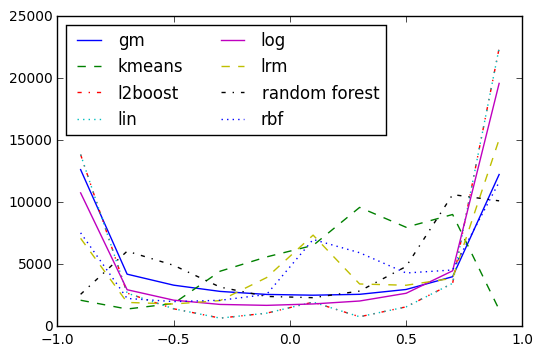

In [181]:
bins = np.linspace(-1, 1, 11)
bincenters = (bins[1:] + bins[0:-1])/2.
for p in allPred.T:
    N, dummy = np.histogram(p, bins)
    plt.plot(bincenters, N, next(linecycler))
plt.legend(predictorNames, ncol=2, loc='best');
plt.savefig('figures/confidence_dist.pdf')

### Find best predictor weights

In [21]:
def multiPredictor(w, predictions):
    w = abs(w)
    predval = (predictions * w).sum(1)
    ypred = np.zeros([len(predval), 1])
    ypred[predval > 0] = 1
    return ypred

def multiPredictorLoss(w, predictions=allPred, regularization=0.1, y=ytrain):
    ypred = multiPredictor(w, predictions)
#     print ypred.shape, y.shape
    L = (ypred != y).mean() + regularization * (w**2).sum()
    return L

#### Fit predictor weights to y in [-1, 1]

In [22]:
# Find function weights that minimize the loss
allPredictorWeights = []
losses = []
for i in range(25):
    print i
    output = fmin(multiPredictorLoss, np.random.rand(len(predictorNames)), full_output=True)
    allPredictorWeights.append(abs(output[0]))
    losses.append(output[1])
    
ind = np.argmin(losses)
predictorWeights = allPredictorWeights[ind]
print ''
print 'Predictor weights: '
ind = np.argsort((-predictorWeights))
for i in ind:
    print predictorNames[i], '\t', predictorWeights[i]
    
bestLoss = multiPredictorLoss(predictorWeights, regularization=0.)
print 'unregularized loss: ', bestLoss
pickle.dump(predictorWeights, open('predictor_weights.p', 'w'), 2)

0
Optimization terminated successfully.
         Current function value: 0.110098
         Iterations: 318
         Function evaluations: 516
1
Optimization terminated successfully.
         Current function value: 0.135723
         Iterations: 498
         Function evaluations: 787
2
Optimization terminated successfully.
         Current function value: 0.138998
         Iterations: 294
         Function evaluations: 475
3
Optimization terminated successfully.
         Current function value: 0.116622
         Iterations: 372
         Function evaluations: 609
4
Optimization terminated successfully.
         Current function value: 0.142606
         Iterations: 396
         Function evaluations: 624
5
Optimization terminated successfully.
         Current function value: 0.119464
         Iterations: 323
         Function evaluations: 533
6
Optimization terminated successfully.
         Current function value: 0.123514
         Iterations: 423
         Function evaluations: 668
7
Opti

In [23]:
ind = np.argsort((-predictorWeights))
norm = np.sum(predictorWeights)
for i in ind:
    print predictorWeights[i]/norm
for i in ind:
    print predictorNames[i]

0.448708219865
0.226834561241
0.106067963182
0.0981170128106
0.0449912493249
0.0299946364147
0.0263595846127
0.0189267725483
random forest
rbf
kmeans
log
gm
lrm
l2boost
lin


#### Test

In [24]:
# Test predictions
testPredictions = {}
for name, predFunc in predFuncs.iteritems():
    print 'Calculating prediction for: ', name
    testPredictions[name] = predFunc(xtest)
pickle.dump(testPredictions, open('predictions_test.p', 'w'))

Calculating prediction for:  log
Calculating prediction for:  lin
Calculating prediction for:  lrm
Calculating prediction for:  kmeans
Calculating prediction for:  rbf
Calculating prediction for:  gm


In [25]:
testPredictions = pickle.load(open('predictions_test.p', 'r'))
testPredictions['random forest'] = forestPredTest
testPredictions['l2boost'] = boostPred(xtest)

In [26]:
allTestPred = [testPredictions[key].T for key in predictorNames]
allTestPred = np.concatenate(allTestPred).T
testLoss = multiPredictorLoss(predictorWeights, allTestPred, regularization=0., y=ytest)

In [27]:
print testLoss

0.11750575518


### Echo losses

In [28]:
print 'Training 0/1 loss\n'
for i, name in enumerate(predictorNames):
    ypred = allPred[:, i, None] > 0
    print (ypred != ytrain).mean()
for i, name in enumerate(predictorNames):
    print name

Training 0/1 loss

0.245581022921
0.290801721549
0.114763286958
0.114783304974
0.113502151937
0.124051646482
0.114022620358
0.159943949555
gm
kmeans
l2boost
lin
log
lrm
random forest
rbf


In [29]:
print 'Test 0/1 loss\n'
for i, name in enumerate(predictorNames):
    ypred = allTestPred[:, i, None] > 0
    print (ypred != ytest).mean()
    
for i, name in enumerate(predictorNames):
    print name

Test 0/1 loss

0.254829346412
0.310579521569
0.123210889801
0.123010709639
0.121108998098
0.132619357422
0.127614853368
0.161545390852
gm
kmeans
l2boost
lin
log
lrm
random forest
rbf


#### Fit predictor weights to y in {-1, 1} (binary

In [165]:
def makeBinaryFromPred(y):
    ybin = np.ones(y.shape)
    ybin[y < 0] = -1
    return ybin

# IMPLEMENT THIS (fit predictor weights to binary y)

In [112]:
ind = abs(lr.w).flatten().argsort()
for i in ind[0:20]:
    print names[i]

speaks_latvian
speaks_serbian
education_ph.d program
sign_taurus
speaks_lisp
speaks_georgian
education_law school
diet_strictly halal
diet_mostly halal
speaks_catalan
speaks_swahili
speaks_ukrainian
speaks_tamil
speaks_albanian
smokes_trying to quit
religion_agnosticism
speaks_esperanto
education_working on med school
sign_aries
speaks_mongolian


217

In [108]:
mask = np.array(['sign' in name for name in featureName